In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg


In [67]:
import matplotlib
matplotlib.rc('font', serif='Calibri')

In [25]:
np.random.seed(9)

In [26]:
img_size = 32
img = np.zeros((img_size,img_size))

In [27]:
def take_step(xy):
    x = np.random.choice([-1,0,1])
    y = np.random.choice([-1,0,1])
    for k,s in enumerate([x,y]):
        if xy[k] + s < img_size and xy[k] + s >= 0:
            xy[k] = xy[k] + s
    return xy

In [28]:
n_steps = int(1e4)
pos = np.random.uniform(0,img_size,size=2).astype(int)
img[pos[0],pos[1]] = 1
for step in range(n_steps):
    pos = take_step(pos)
    img[pos[0],pos[1]] += 1
    

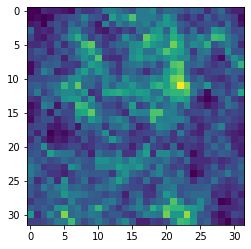

In [29]:
im = plt.imshow(img)
plt.colorbar
plt.show()

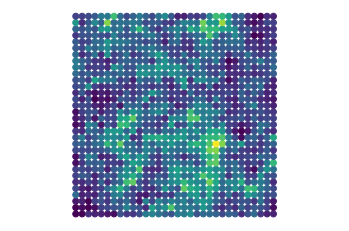

In [30]:
xx = np.arange(-img_size/2,img_size/2)
xx,yy = np.meshgrid(xx,xx)
crd = np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))
vals = img.flatten()
plt.scatter(crd[:,0],crd[:,1],c = vals)
plt.axis("equal")
plt.axis("off")
plt.show()

In [31]:
n_max_lmks = 50
n_lmks = np.linspace(3,n_max_lmks-1,10).astype(int)
lmk_idx = np.random.choice(np.arange(vals.shape[0]),size =n_max_lmks,replace =False).astype(int)
lmk = crd[lmk_idx,:]

(-20.66126983722081, 19.66126983722081, -20.66126983722081, 19.66126983722081)

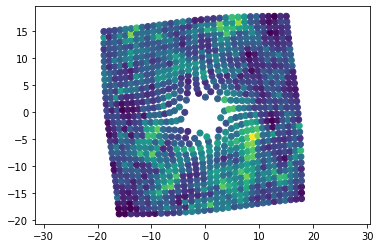

In [32]:
h = 2
x = np.linspace(-h,h,32)
y = np.linspace(-h,h,32)
x,y = np.meshgrid(x,y)

u = (-y + x)/np.sqrt(x**2 + y**2) * 2
v = (x + y)/np.sqrt(x**2 + y**2) * 2


new_xx = xx.flatten() + u.flatten()
new_yy = yy.flatten() + v.flatten()

new_crd = np.hstack((new_xx[:,np.newaxis],new_yy[:,np.newaxis]))
new_lmk = new_crd[lmk_idx,:]
plt.scatter(new_crd[:,0],new_crd[:,1],c  = vals)
plt.axis("equal")

In [33]:
from scipy.interpolate import griddata
new_vals = griddata(new_crd,vals,(xx,yy),method = "nearest")
new_vals = new_vals.flatten()

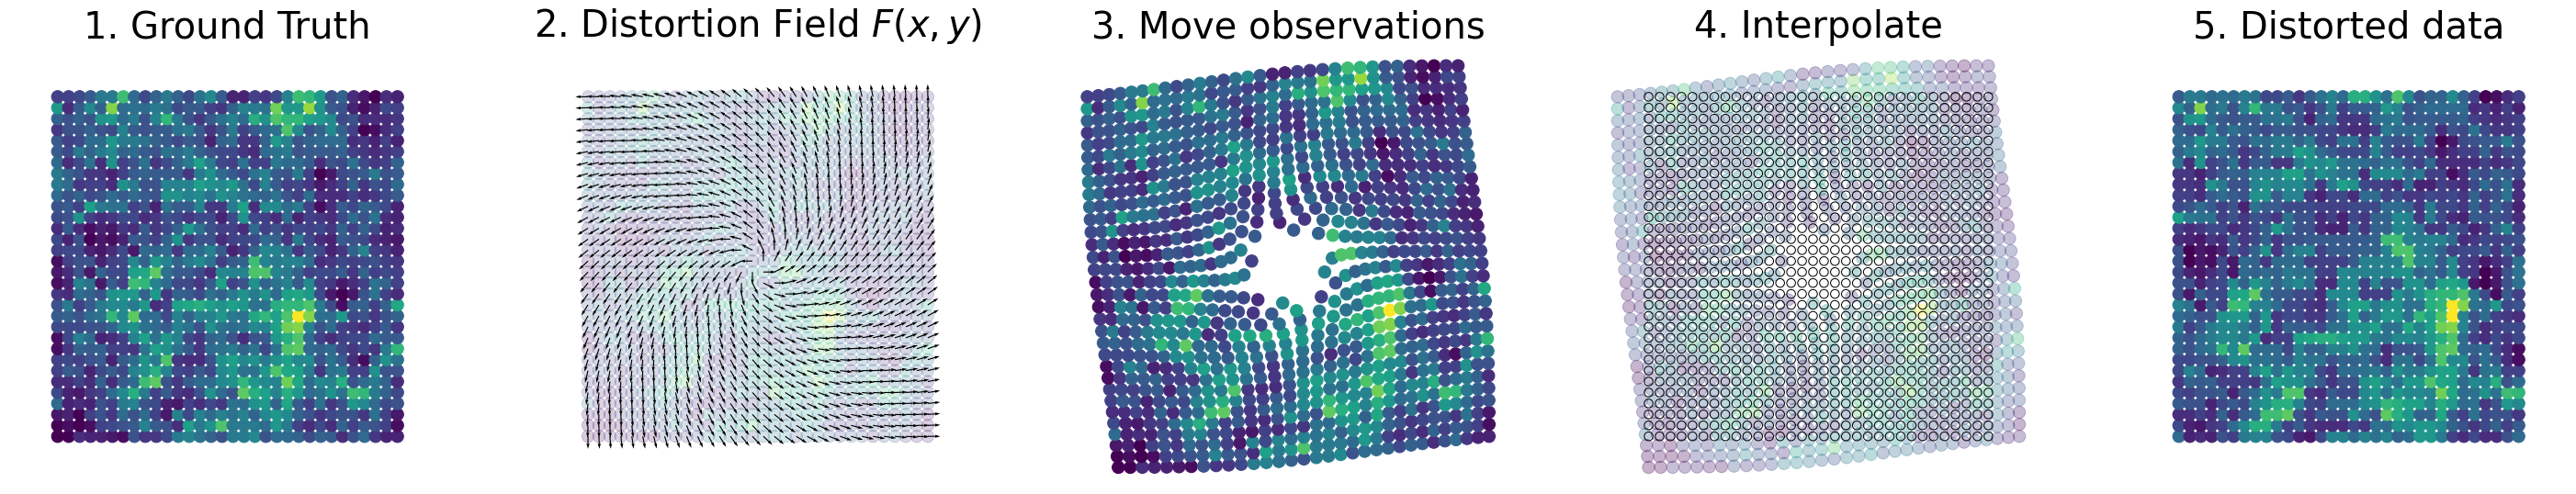

In [126]:
fz = 40
marker_size  = 180
fig,ax = plt.subplots(1,5,sharex=True,sharey=True,figsize = (50,10))

ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size)
ax[1].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size,alpha = 0.2)
ax[1].quiver(xx,yy,u,v,scale =100)
ax[2].scatter(new_crd[:,0],new_crd[:,1],c = vals,s=marker_size)
ax[3].scatter(new_crd[:,0],new_crd[:,1],c = vals,s=marker_size,alpha=0.3)
ax[3].scatter(crd[:,0],crd[:,1],s=marker_size / 2,facecolor = "none",edgecolor = "black")
ax[4].scatter(crd[:,0],crd[:,1],c = new_vals,s=marker_size)

ax[0].set_title("1. Ground Truth",fontsize=fz)
ax[1].set_title(r"2. Distortion Field $F(x,y)$",fontsize=fz)
ax[2].set_title("3. Move observations",fontsize=fz)
ax[3].set_title("4. Interpolate",fontsize=fz)
ax[4].set_title("5. Distorted data",fontsize=fz)

for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")


In [82]:
from typing import Union,Optional,Dict,List,Tuple,Any,TypeVar
T = TypeVar('T') 

class ColorMapper:
    def __init__(self,
                 cmap: Dict[T,str],
                 )->None:

        self.n_c = len(cmap)
        self.cdict = cmap
        if not all([isinstance(x,int) for x in self.cdict.keys()]):
            self.numeric_cdict = {k:c for k,c in enumerate(cdict.keys())}
        else:
            self.numeric_cdict = self.cdict

    def __call__(self,
                 x:Union[T,np.ndarray],
                 n_elements: bool = False,
                 )->Union[str,np.ndarray]:

        if hasattr(x,"__len__") or n_elements:
            if n_elements:
                n = x
            else:
                n = len(x)
            clr = [self.numeric_cdict[ii % self.n_c] for ii in range(n)]
            clr = np.array(clr)
        else:
            if x in self.cdict.keys():
                clr = self.cdict[x]
            else:
                raise ValueError(f"{x} is not supported as value.")
        return clr

In [83]:
color_mapper = ColorMapper(eg.constants.LANDMARK_CMAP)


array(['orange', 'red', 'blue', 'green', 'pink', 'magenta', 'yellow',
       'gray', 'cyan', 'orange', 'red', 'blue', 'green', 'pink',
       'magenta', 'yellow', 'gray', 'cyan', 'orange', 'red', 'blue',
       'green', 'pink', 'magenta', 'yellow', 'gray', 'cyan', 'orange',
       'red', 'blue', 'green', 'pink', 'magenta', 'yellow', 'gray',
       'cyan', 'orange', 'red', 'blue', 'green', 'pink', 'magenta',
       'yellow', 'gray', 'cyan', 'orange', 'red', 'blue', 'green'],
      dtype='<U7')

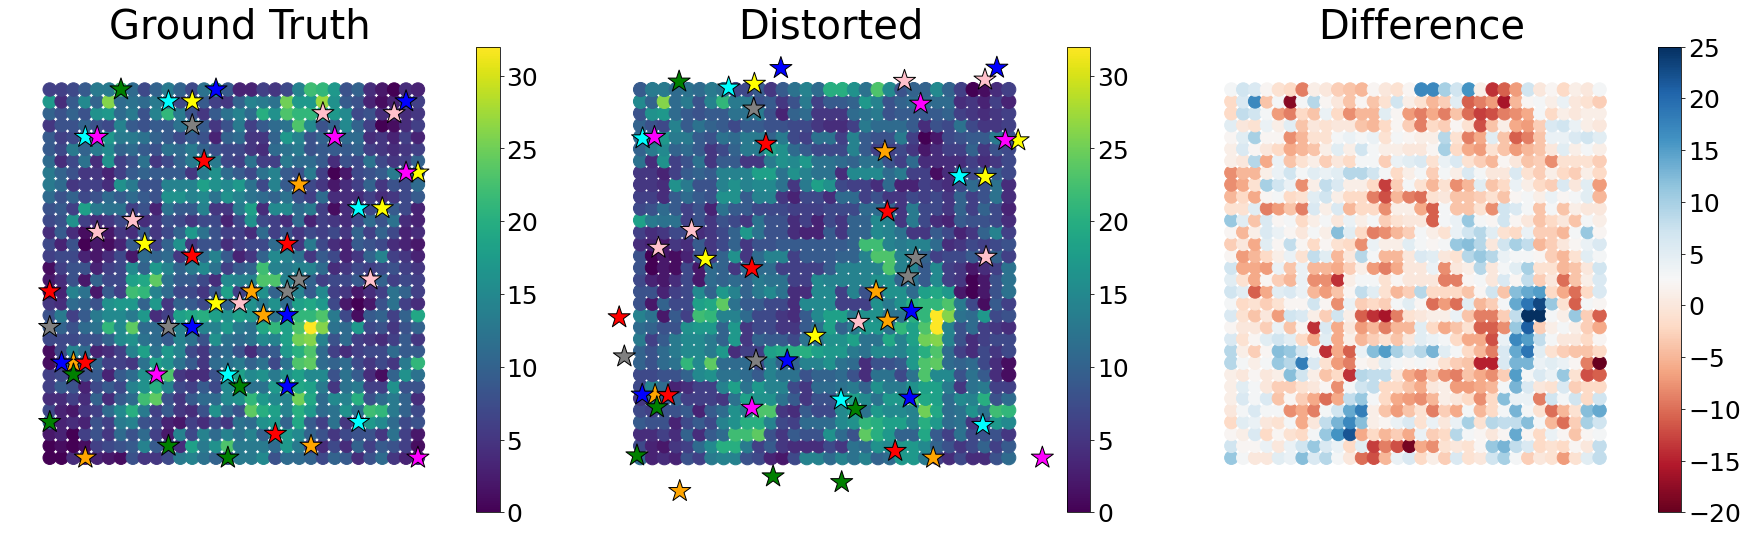

In [119]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

color_mapper = ColorMapper(eg.constants.LANDMARK_CMAP)

fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize = (30,10))

scs = [None] * 3

scs[0] = ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size)
ax[0].set_title("Ground Truth",fontsize = fz)
ax[0].scatter(lmk[:,0],
              lmk[:,1],
              c = color_mapper(lmk),
              s = marker_size * 3,
              marker = "*",
              edgecolor ="black",
              )

scs[1] = ax[1].scatter(crd[:,0],crd[:,1],c = new_vals,s=200)
ax[1].scatter(new_lmk[:,0],
              new_lmk[:,1],
              c =color_mapper(new_lmk),
              s = marker_size * 3,
              marker = "*",
              edgecolor ="black",
             )

ax[1].set_title("Distorted",fontsize = fz)

scs[2] = ax[2].scatter(crd[:,0],
                    crd[:,1],
                    c = new_vals - vals,
                    s=marker_size,
                    cmap = plt.cm.RdBu)

for k in range(len(scs)):
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scs[k], cax=cax)
    cbar.ax.tick_params(labelsize = 25)

ax[2].set_title("Difference",fontsize = fz)


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")
    
plt.show()

In [36]:
X = np.hstack((vals[:,np.newaxis],new_vals[:,np.newaxis]))
var = pd.DataFrame(["original","distorted"],
                   index = ["original","distorted"],
                   columns = ["values"],
                  )
obs_index = [f"Location_{k}" for k in range(vals.shape[0])]
obs = pd.DataFrame(obs_index,
                   index = obs_index,
                   columns = ["location"],
                  )
adata = ad.AnnData(X,
                   var = var,
                   obs = obs,
                  )

adata.obsm["spatial"] = crd

adata

AnnData object with n_obs × n_vars = 1024 × 2
    obs: 'location'
    var: 'values'
    obsm: 'spatial'

In [37]:
def rmse(x,y):
    return np.mean((x - y)**2)

In [38]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [39]:
import morphops as mops

In [40]:
n_reps = 3
columns = [f"Rep_{k}" for k in range(n_reps)]
index = n_lmks

egg_res_df = np.zeros((len(index),len(columns)))
tps_res_df = np.zeros((len(index),len(columns)))
true_X = adata.X[:,0].flatten()

for k,n_l in enumerate(n_lmks):
    for ii in range(n_reps):
        sel_lmk = np.random.choice(n_max_lmks,replace = False,size = n_l)
        ref = eg.m.Reference(domain=crd,
                             landmarks = lmk[sel_lmk,:],
                            )
        
        _adata = adata[:,1]
        _adata.uns["curated_landmarks"] = new_lmk[sel_lmk,:]
        
        eg.pp.match_scales(_adata,ref)
        eg.pp.get_landmark_distance(_adata,
                                    reference=ref)
        
        losses = eg.fun.transfer_to_reference(_adata,
                                              ["distorted"],
                                              ref,
                                               n_epochs=1000,
                                            device ="gpu",
                                            verbose = True,
                                            return_losses = True,
                                            return_models =False,
                                           max_cg_iterations = 10000,
                                           )
        
        egg_X = ref.adata.X.flatten()
        egg_res_df[k,ii] = rmse(egg_X,true_X)
        
        tps_crd = mops.tps_warp(new_lmk[sel_lmk,:],lmk[sel_lmk,:],crd)
        tps_X = griddata(tps_crd,adata.X[:,1].flatten(),(xx,yy),method = "nearest").flatten()
        tps_res_df[k,ii] = rmse(tps_X,true_X)
        
        
tps_res_df = pd.DataFrame(tps_res_df,
                         columns = columns,
                          index = index,
                         ) 

egg_res_df = pd.DataFrame(egg_res_df,
                          columns = columns,
                          index = index,
                         )

Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


  0%|                          | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(
100%|███████████████| 1000/1000 [00:21<00:00, 47.31it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.06it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.05it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.09it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.04it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.83it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.22it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.64it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.65it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.70it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.57it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.71it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:20<00:00, 48.40it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.21it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.04it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.60it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.87it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.43it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.13it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.45it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.35it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.60it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.29it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:20<00:00, 48.00it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.13it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.42it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.68it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.06it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 47.12it/s]
Trying to set attribute `.uns` of view, copying.


Processing >> Model : Model_0 | Feature : distorted


100%|███████████████| 1000/1000 [00:21<00:00, 46.87it/s]


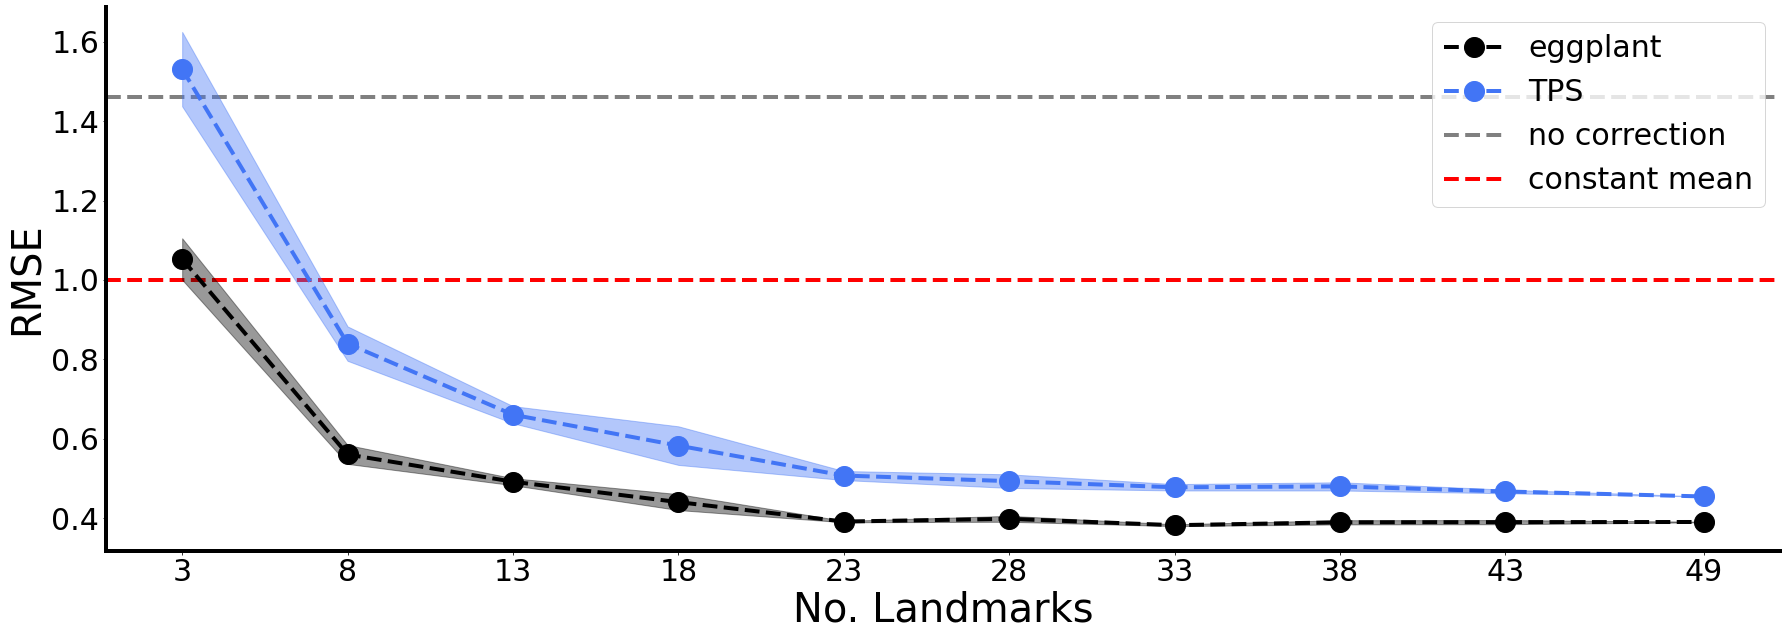

In [138]:
obs_baseline =  rmse(adata.X[:,1].flatten(),adata.X[:,0].flatten())
mean_baseline = rmse(adata.X[:,0].flatten(),np.repeat(np.mean(adata.X[:,0]),len(adata)))

fig,ax = plt.subplots(1,1,figsize = (30,10))

for df,clr,label in zip([egg_res_df,tps_res_df],["black","#4275f5"],["eggplant","TPS"]):
    mean_vals = df.values.mean(axis=1)
    std = df.values.std(axis=1)
    ax.plot(df.index.values,
             mean_vals,
             marker = "o",
             linestyle = "dashed",
             color = clr,
             label  = label,
            markersize = 20,
            linewidth = 4,
            )
    se = std / np.sqrt(egg_res_df.shape[1])
    ax.fill_between(df.index.values,
                     mean_vals - se,
                     mean_vals + se,
                     color = clr,
                     alpha = 0.4,
                    )

ax.axhline(y =obs_baseline,
           color = "gray",
           linewidth = 4,
           linestyle = "dashed",
           label = "no correction",zorder = -np.inf)

ax.axhline(y =mean_baseline,
           color = "red",
           linewidth = 4,
           linestyle = "dashed",
           label = "constant mean",zorder = -np.inf)

ax.set_ylabel("RMSE",fontsize  =fz,family="serif")
ax.set_xlabel("No. Landmarks",fontsize = fz,family="serif")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(4)
ax.spines["bottom"].set_linewidth(4)
ax.set_xticks(n_lmks)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(fontsize=30)

plt.show()